# G5.89

TODO: find a disk candidate in the cube; it's not obvious there is one!

MM15 might be a disk candidate

Ferndandez-Lopez+ 2021: https://ui.adsabs.harvard.edu/abs/2021ApJ...913...29F/abstract

Distance from FL2021 originally Sato 2014

MM15 is "edgeondisk" in the regions.

MM4 is `regd1`

s6/s8 and the O5V "feldt's star" are in `regd2`

In [71]:
from astropy import units as u
distance = 3*u.kpc

In [72]:
cd /orange/adamginsburg/salt/sanhueza/G5.89/

/orange/adamginsburg/salt/sanhueza/G5.89


In [73]:
ls

disk1_NaCl_v_le_3_stackcube.fits
disk2_NaCl_v_le_3_stackcube.fits
diskcandidate1.reg
diskcandidate2.reg
edgeondisk.reg
G5.89-0.37.config8.allchannels_avg.selfcal_0.5_hogbom.image.fits
G5.89-0.37.config8.spw0.robust0.5.image_cb_small.fits
G5.89-0.37.config8.spw0.robust0.5.image_d1_smaller.fits
G5.89-0.37.config8.spw0.robust0.5.image_d2_smaller.fits
G5.89-0.37.config8.spw0.robust0.5.image_edgeondisk_smaller.fits
G5.89-0.37.config8.spw0.robust0.5.image_small.fits
G5.89-0.37.config8.spw1.robust0.5.image_cb_small.fits
G5.89-0.37.config8.spw1.robust0.5.image_d1_smaller.fits
G5.89-0.37.config8.spw1.robust0.5.image_d2_smaller.fits
G5.89-0.37.config8.spw1.robust0.5.image_edgeondisk_smaller.fits
G5.89-0.37.config8.spw1.robust0.5.image_small.fits*
G5.89-0.37.config8.spw2.robust0.5.image_cb_small.fits
G5.89-0.37.config8.spw2.robust0.5.image_d1_smaller.fits
G5.89-0.37.config8.spw2.robust0.5.image_d2_smaller.fits
G5.89-0.37.config8.spw2.robust0.5.image_edgeondisk_smaller.fits
G5.89-0.37.config8.spw2

In [74]:
%matplotlib inline
import pylab as pl
from spectral_cube import SpectralCube
from astropy import units as u
from astropy.visualization import quantity_support
quantity_support()

<astropy.visualization.units.quantity_support.<locals>.MplQuantityConverter at 0x2b197bd3fa30>

In [75]:
from astropy.table import Table
from astropy import table

In [76]:
import pprint

In [77]:
import scipy, scipy.ndimage

In [78]:
import numpy as np
import os
import glob
from astropy import constants, units as u, table, stats, coordinates, wcs, log, coordinates as coord
import radio_beam
import pyspeckit
import pylab as pl
pl.rcParams['figure.facecolor'] = 'w'
from astroquery.splatalogue.utils import minimize_table as mt
import sys
sys.path.append('/orange/adamginsburg/salt/Orion_ALMA_2016.1.00165.S/analysis')
import lines
import paths
from salt_tables import (salt_tables, salt_table_names, SO, SO2, HCl, sis_tables, AlCl, AlF, Al37Cl,
                         NaF, AlO, AlOH, NaCN, CaS, CaO)

In [79]:
import regions
from astropy import units as u, coordinates
#reg = regions.Regions.read('big.reg')
regsm = regions.Regions.read('edgeondisk.reg')
regd1 = regions.Regions.read('diskcandidate1.reg')
regd2 = regions.Regions.read('diskcandidate2.reg')
#egvsm = regions.Regions.read('sourceAsmaller.reg')
#regvvsm = regions.Regions.read('.reg')

In [80]:
from astropy.visualization import simple_norm

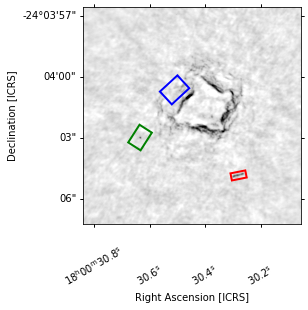

In [81]:
cont = SpectralCube.read('G5.89-0.37.config8.allchannels_avg.selfcal_0.5_hogbom.image.fits')[:,2000:-2050,2000:-2050]
ax = pl.subplot(projection=cont.wcs.celestial)
ax.imshow(cont[0].value, cmap='gray_r', norm=simple_norm(cont[0].value, max_percent=99.95, min_percent=1))
for regs, color in zip((regsm, regd1, regd2), ('r', 'g', 'b')):
    regs[0].to_pixel(cont.wcs.celestial).plot(ax=ax, edgecolor=color, facecolor='none')
ax.coords['ra'].set_axislabel("Right Ascension [ICRS]")
ax.coords['dec'].set_axislabel("Declination [ICRS]")
ax.coords['ra'].set_ticklabel(rotation=30, pad=50)
pl.savefig("G5.89_regions_overview.png", bbox_inches='tight')
pl.savefig("G5.89_regions_overview.pdf", bbox_inches='tight')

# NaCl Stackl

In [82]:
from spectral_cube.analysis_utilities import stack_cube

In [83]:
nacltables = salt_tables[3:5]

In [84]:
import spectral_cube.analysis_utilities
import imp
imp.reload(spectral_cube.analysis_utilities)
from spectral_cube.analysis_utilities import stack_cube

In [85]:
flist = sorted(glob.glob('G5.89-0.37.config8.spw[0-3].robust0.5.image_small.fits'))

In [86]:
for fn in flist:
    for rr,regn in ((regsm, 'edgeondisk'), (regd1, 'd1'), (regd2, 'd2')):
        outfile = fn.replace("_small",f"_{regn}_smaller")
        if not os.path.exists(outfile) or (os.path.exists(outfile) and SpectralCube.read(outfile).unit != u.K):
            cube = SpectralCube.read(fn, use_dask=True).subcube_from_regions(rr)
            cube.allow_huge_operations=True
            with cube.use_dask_scheduler('threads', num_workers=8):
                cb = cube.beams.common_beam(max_iter=20, max_epsilon=0.01)
                scube = cube.convolve_to(cb, save_to_tmp_dir=True)
            scube.allow_huge_operations = True
            scube.to(u.K).write(outfile, overwrite=True)        

In [87]:
cbflist = sorted((glob.glob('G5.89-0.37.config8.spw[0-3].robust0.5.image_cb_small.fits')))
cubes = [SpectralCube.read(fn).subcube_from_regions(regd1).to(u.K) for fn in cbflist]
cubes

[SpectralCube with shape=(1920, 126, 115) and unit=K:
  n_x:    115  type_x: RA---SIN  unit_x: deg    range:   270.127469 deg:  270.127815 deg
  n_y:    126  type_y: DEC--SIN  unit_y: deg    range:   -24.067666 deg:  -24.067319 deg
  n_s:   1920  type_s: FREQ      unit_s: Hz     range: 233565132698.900 Hz:235439188519.174 Hz,
 SpectralCube with shape=(1920, 126, 115) and unit=K:
  n_x:    115  type_x: RA---SIN  unit_x: deg    range:   270.127469 deg:  270.127815 deg
  n_y:    126  type_y: DEC--SIN  unit_y: deg    range:   -24.067666 deg:  -24.067319 deg
  n_s:   1920  type_s: FREQ      unit_s: Hz     range: 231065109664.600 Hz:232939165484.874 Hz,
 SpectralCube with shape=(1920, 126, 115) and unit=K:
  n_x:    115  type_x: RA---SIN  unit_x: deg    range:   270.127469 deg:  270.127815 deg
  n_y:    126  type_y: DEC--SIN  unit_y: deg    range:   -24.067666 deg:  -24.067319 deg
  n_s:   1920  type_s: FREQ      unit_s: Hz     range: 216864978830.100 Hz:218739034650.374 Hz,
 SpectralCube wi

In [88]:
# only needed for VRSCs
if hasattr(cubes[0], 'beams'):
    beams = radio_beam.Beams(beams=[cube.beams.common_beam(max_iter=20, max_epsilon=0.01) for cube in cubes])
    cb=beams.common_beam()
else:
    cb = cubes[0].beam

In [89]:
cb

Beam: BMAJ=0.05795148657317544 arcsec BMIN=0.04095939016036116 arcsec BPA=66.31839430366688 deg

In [90]:
(cb.major*distance).to(u.au, u.dimensionless_angles())

<Quantity 173.85445972 AU>

In [91]:
(cb.minor*distance).to(u.au, u.dimensionless_angles())

<Quantity 122.87817048 AU>

In [92]:
linelist = np.concatenate([data['Freq'][(data['vu'] <= 3) &
                                          np.any([((data['Freq'].quantity > cube.spectral_extrema[0]) &
                                                   (data['Freq'].quantity < cube.spectral_extrema[1]))
                                                 for cube in cubes],
                                                 axis=0)].quantity
                             for data in nacltables])
linenames = np.concatenate( [data['Species'][(data['vu'] <= 3) &
                                          np.any([((data['Freq'].quantity > cube.spectral_extrema[0]) &
                                                   (data['Freq'].quantity < cube.spectral_extrema[1]))
                                                 for cube in cubes],
                                                 axis=0)]
                             for data in nacltables] )
(linelist, linenames)

(<Quantity [217.980231, 219.614936, 232.509977, 234.251912] GHz>,
 array(['23Na-35Clv=2-2 J=17-16', '23Na-35Clv=1-1 J=17-16',
        '23Na-35Clv=1-1 J=18-17', '23Na-35Clv=0-0 J=18-17'], dtype='<U24'))

In [93]:
from astropy import log
log.setLevel('INFO')

In [94]:
cubes

[SpectralCube with shape=(1920, 126, 115) and unit=K:
  n_x:    115  type_x: RA---SIN  unit_x: deg    range:   270.127469 deg:  270.127815 deg
  n_y:    126  type_y: DEC--SIN  unit_y: deg    range:   -24.067666 deg:  -24.067319 deg
  n_s:   1920  type_s: FREQ      unit_s: Hz     range: 233565132698.900 Hz:235439188519.174 Hz,
 SpectralCube with shape=(1920, 126, 115) and unit=K:
  n_x:    115  type_x: RA---SIN  unit_x: deg    range:   270.127469 deg:  270.127815 deg
  n_y:    126  type_y: DEC--SIN  unit_y: deg    range:   -24.067666 deg:  -24.067319 deg
  n_s:   1920  type_s: FREQ      unit_s: Hz     range: 231065109664.600 Hz:232939165484.874 Hz,
 SpectralCube with shape=(1920, 126, 115) and unit=K:
  n_x:    115  type_x: RA---SIN  unit_x: deg    range:   270.127469 deg:  270.127815 deg
  n_y:    126  type_y: DEC--SIN  unit_y: deg    range:   -24.067666 deg:  -24.067319 deg
  n_s:   1920  type_s: FREQ      unit_s: Hz     range: 216864978830.100 Hz:218739034650.374 Hz,
 SpectralCube wi

In [95]:

for reg, regn in ((regsm, 'edgeondisk'), (regd1, 'd1'), (regd2, 'd2')):
    cbflist = sorted((glob.glob('G5.89-0.37.config8.spw[0-3].robust0.5.image_cb_small.fits')))
    cubes = [SpectralCube.read(fn).subcube_from_regions(reg).to(u.K) for fn in cbflist]

    vcen = 10 * u.km/u.s # from Patricio
    stack, cutouts = stack_cube(cubes,
                       linelist=linelist,
                       vmin=vcen-30*u.km/u.s,
                       vmax=vcen+30*u.km/u.s,
                       average=np.nanmean,
                       convolve_beam=cb,
                       return_cutouts=True)
    #log.setLevel('INFO')
    stack.write(f'{regn}_NaCl_v_le_3_stackcube.fits', overwrite=True)

Mean of empty slice
Mean of empty slice
Mean of empty slice


#log.setLevel('DEBUG')
vcen = 10 * u.km/u.s # from Patricio
stack, cutouts = stack_cube(cubes,
                   linelist=linelist,
                   vmin=vcen-30*u.km/u.s,
                   vmax=vcen+30*u.km/u.s,
                   average=np.nanmean,
                   convolve_beam=cb,
                   return_cutouts=True)
#log.setLevel('INFO')
stack.write('NaCl_v_le_3_stackcube.fits', overwrite=True)

In [96]:
stackc = SpectralCube.read('edgeondisk_NaCl_v_le_3_stackcube.fits')
stackc

SpectralCube with shape=(46, 49, 80) and unit=K:
 n_x:     80  type_x: RA---SIN  unit_x: deg    range:   270.126048 deg:  270.126288 deg
 n_y:     49  type_y: DEC--SIN  unit_y: deg    range:   -24.068077 deg:  -24.067944 deg
 n_s:     46  type_s: VRAD      unit_s: km / s  range:      -20.149 km / s:      40.291 km / s

In [97]:
jtok = stackc.beam.jtok(217*u.GHz)

All-NaN slice encountered
invalid value encountered in true_divide


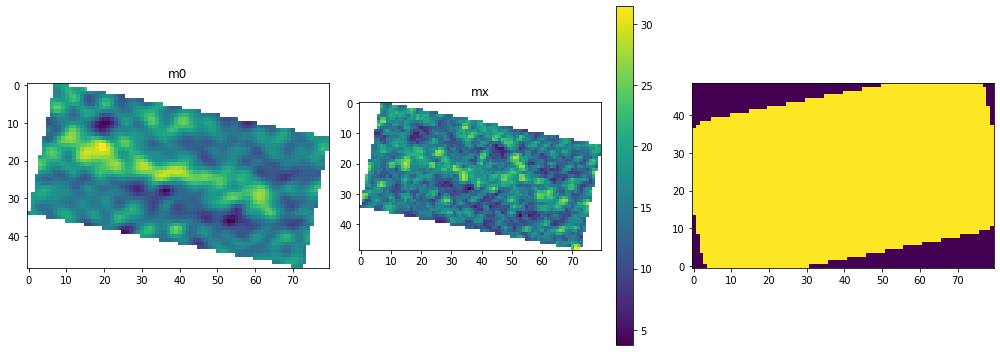

<Figure size 432x288 with 0 Axes>

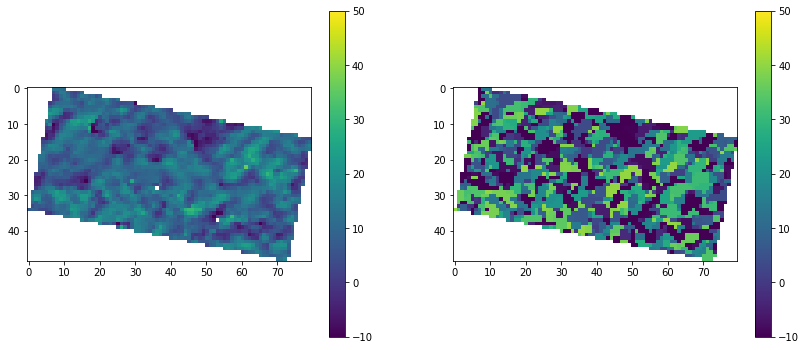

In [98]:
stackc = stackc.subcube_from_regions(regsm)
pl.figure(figsize=(14,5))
pl.subplot(1,3,1)
m0 = stackc.moment0()
m0.quicklook()
pl.title("m0")

pl.subplot(1,3,2)
mx = stackc.max(axis=0)
mx.quicklook()
pl.title("mx")
pl.colorbar()
pl.subplot(1,3,3)
msk = mx > 0.00016*jtok
msk = scipy.ndimage.binary_erosion(msk, iterations=1)
msk = scipy.ndimage.binary_dilation(msk, iterations=5)
pl.imshow(msk, interpolation='none', origin='lower')
pl.tight_layout()
pl.figure()


m1 = stackc.with_mask(msk).with_mask(stackc > 0.0005*jtok).moment1()
pl.figure(figsize=(14,6))
ax1 = pl.subplot(1,2,1)
im = ax1.imshow(m1.value, vmin=-10, vmax=50)
pl.colorbar(mappable=im)
mxv = stackc.with_mask(msk).argmax_world(axis=0)
pl.subplot(1,2,2)
pl.imshow(mxv.value, vmin=-10, vmax=50)
pl.colorbar()
#pl.suptitle("This vmap is not used.")


# use water
# vmap = mxv.hdu

All-NaN slice encountered
invalid value encountered in true_divide


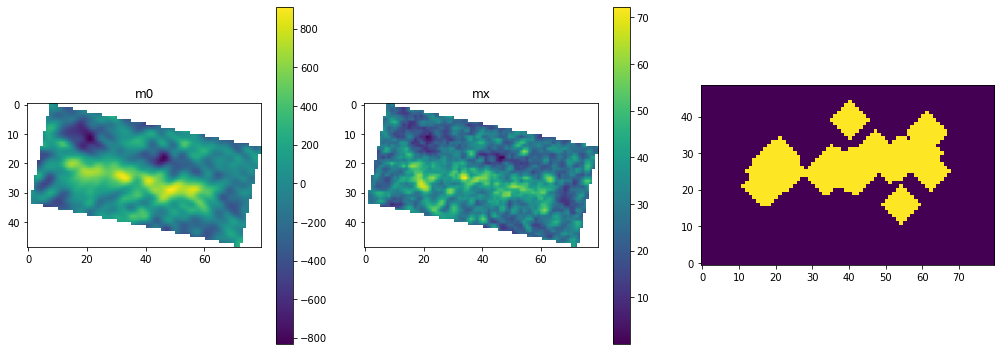

<Figure size 432x288 with 0 Axes>

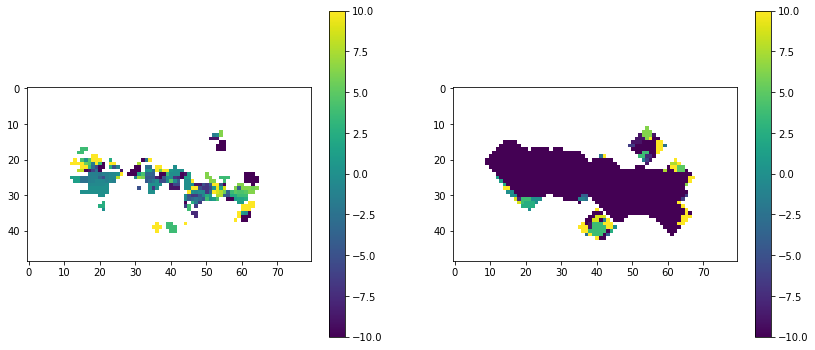

In [113]:
# try creating a vmap based on another line
restval = 232.3929*u.GHz # this is maybe 33SO2?  Probably not...
restval = 231.9811*u.GHz # eyeballed
#restval = 232.4128*u.GHz # eyeballed

#restval = 232.6867*u.GHz # 'H2Ov2=1_5(5,0)-6(4,3)': 
cubes = [SpectralCube.read(fn) for fn in cbflist]
cube = [c.subcube_from_regions(regsm).to(u.K) for c in cubes if (c.spectral_extrema[0] < restval) & (c.spectral_extrema[1] > restval)][0]

scube = cube.subcube_from_regions(regsm).with_spectral_unit(u.km/u.s, velocity_convention='radio', rest_value=restval).spectral_slab(-20*u.km/u.s, 20*u.km/u.s)
pl.figure(figsize=(14,5))
pl.subplot(1,3,1)
m0 = scube.moment0()
m0.quicklook()
pl.title("m0")
pl.colorbar()

pl.subplot(1,3,2)
mx = scube.max(axis=0)
mx.quicklook()
pl.title("mx")
pl.colorbar()
pl.subplot(1,3,3)
msk = mx > 45*u.K
msk = scipy.ndimage.binary_erosion(msk, iterations=1)
msk = scipy.ndimage.binary_dilation(msk, iterations=5)
pl.imshow(msk, interpolation='none', origin='lower')
pl.tight_layout()
pl.figure()


m1 = scube.with_mask(msk).with_mask(scube > 40*u.K).moment1()
pl.figure(figsize=(14,6))
ax1 = pl.subplot(1,2,1)
im = ax1.imshow(m1.value, vmin=-10, vmax=10)
pl.colorbar(mappable=im)
mxv = scube.with_mask(msk).argmax_world(axis=0)
pl.subplot(1,2,2)
pl.imshow(mxv.value, vmin=-10, vmax=10)
pl.colorbar()


vmap = mxv.hdu
vmap = m1.hdu

# just force it to 10 km/s because for the edge-on disk, there are no clear line detctions
vmap.data[:] = 10
msk = m0 > 400*m0.unit
msk = scipy.ndimage.binary_erosion(msk, iterations=1)
msk = scipy.ndimage.binary_dilation(msk, iterations=5)
vmap.data[~msk] = np.nan
pl.imshow(vmap.data)
# the rest value selected above was just the line center; we need to assume it's really 35 km/s off
#vmap.data = vmap.data + vcen.value

In [114]:
import sys
sys.path.append('/orange/adamginsburg/salt/code/')
from overplot_saltlines import overplot_saltlines

In [115]:
spectra = []
for ii,cube in enumerate(cubes):
    cube.allow_huge_operations=True
    sp = cube.subcube_from_regions(regsm).to(u.K).mean(axis=(1,2))
    pysp = pyspeckit.Spectrum(data=sp, xarr=sp.spectral_axis, header=sp.header)
    spectra.append(pysp)
    pysp.specname = f'spw{ii+1}'

In [116]:
mkdir -p spectra/figures

spw1
spw2
spw3
spw4


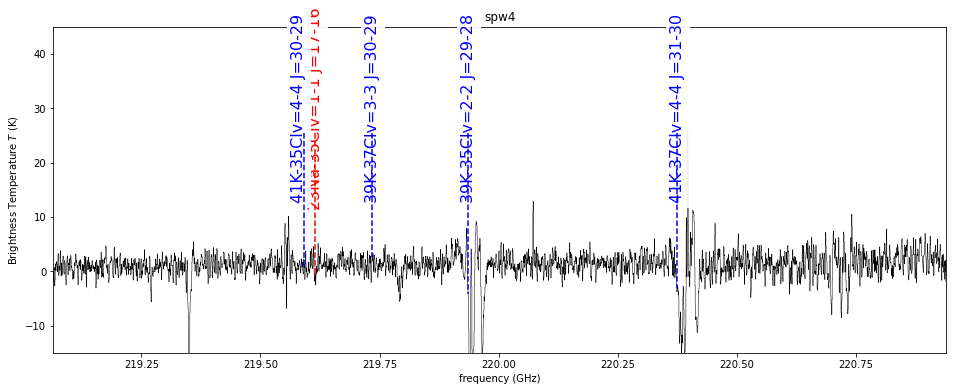

In [117]:
overplot_saltlines(spectra, vcen=0*u.km/u.s, savepath='spectra/figures', ymin=-15, ymax=45)

In [32]:
ls spectra/figures

color_labels_G5.89-0.37_spw0_stack.png
color_labels_G5.89-0.37_spw1_stack.png
color_labels_G5.89-0.37_spw2_stack.png
color_labels_G5.89-0.37_spw3_stack.png
color_labels_spw1.png
color_labels_spw2.png
color_labels_spw3.png
color_labels_spw4.png
G5.89-0.37.config8.spw0.robust0.5.image_cb_small_stack.pdf
G5.89-0.37.config8.spw0.robust0.5.image_cb_small_stack.png
G5.89-0.37.config8.spw1.robust0.5.image_cb_small_stack.pdf
G5.89-0.37.config8.spw1.robust0.5.image_cb_small_stack.png
G5.89-0.37.config8.spw2.robust0.5.image_cb_small_stack.pdf
G5.89-0.37.config8.spw2.robust0.5.image_cb_small_stack.png
G5.89-0.37.config8.spw3.robust0.5.image_cb_small_stack.pdf
G5.89-0.37.config8.spw3.robust0.5.image_cb_small_stack.png
G5.89-0.37_spw0_stack.png
G5.89-0.37_spw1_stack.png
G5.89-0.37_spw2_stack.png
G5.89-0.37_spw3_stack.png
spw1.png
spw2.png
spw3.png
spw4.png


In [33]:
from IPython.display import Image,display

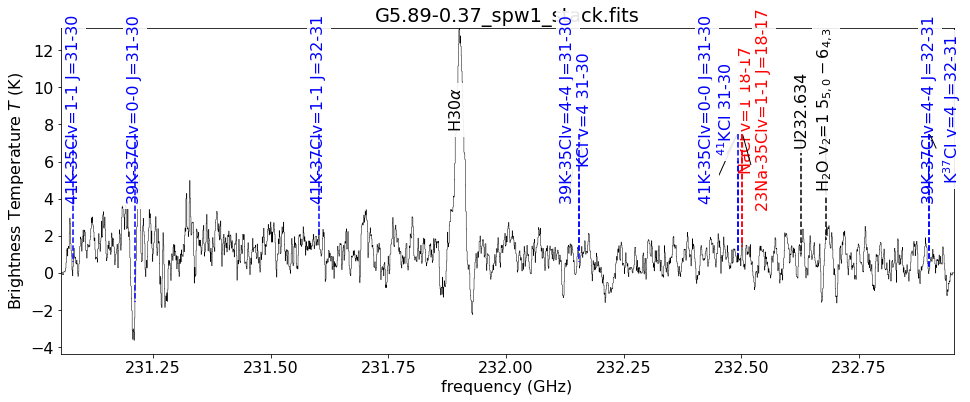

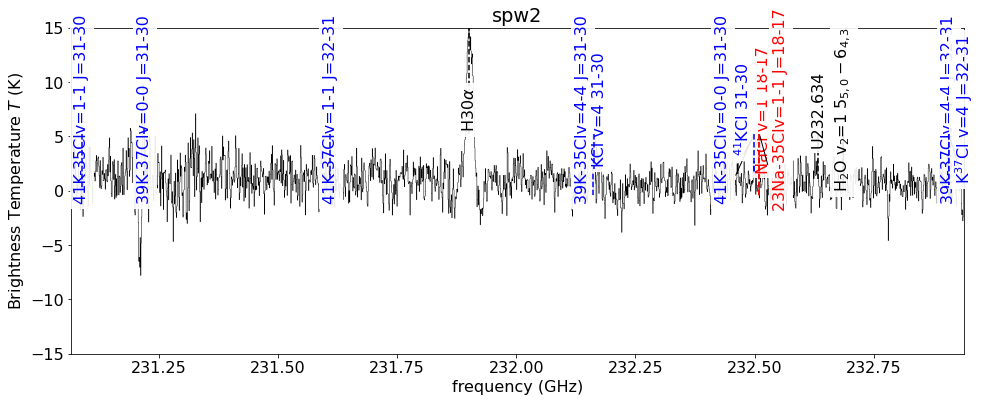

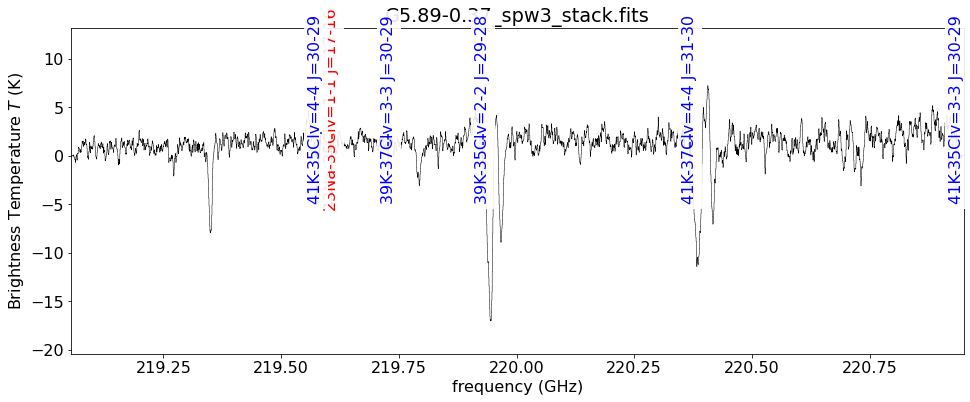

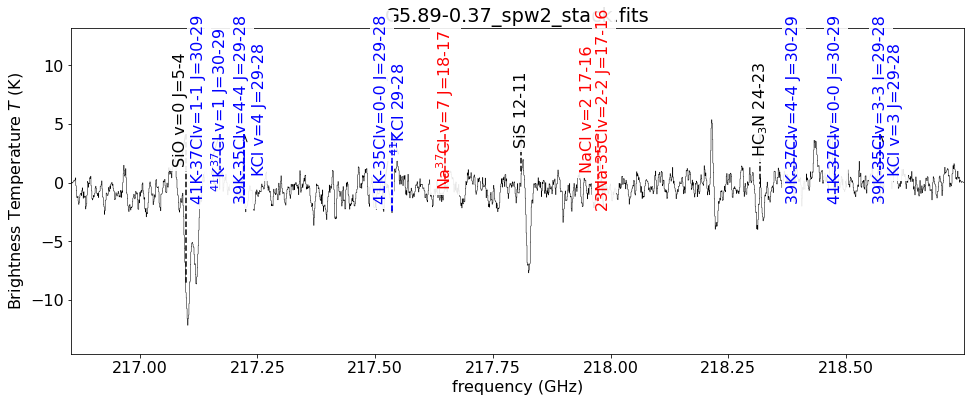

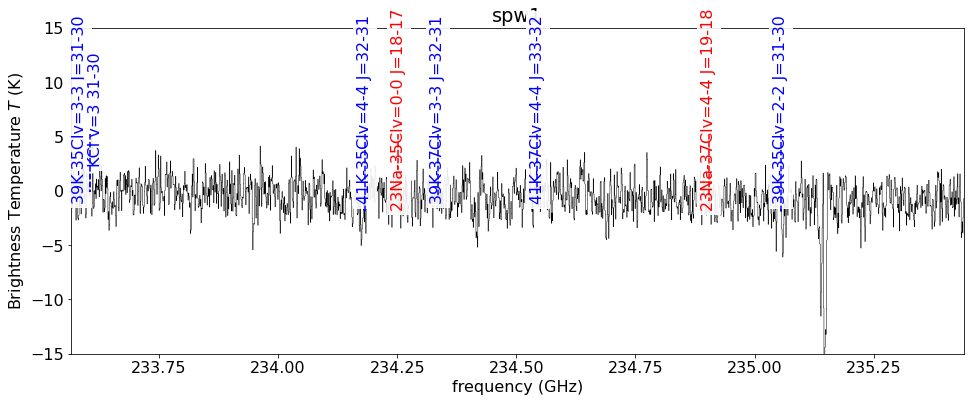

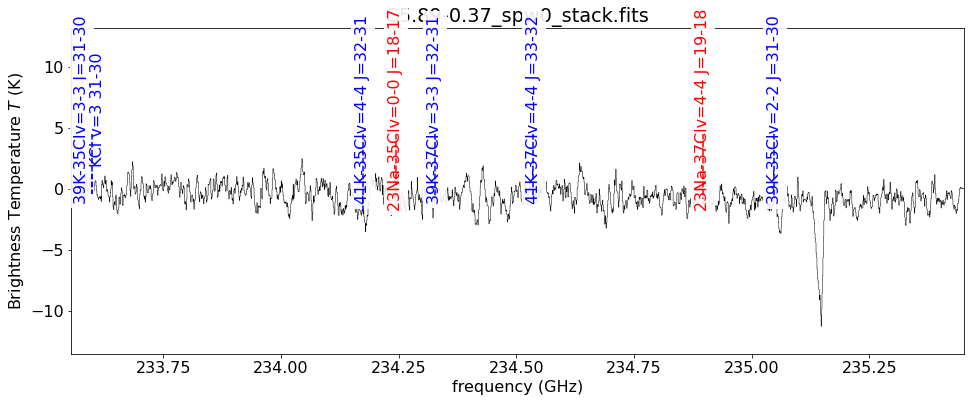

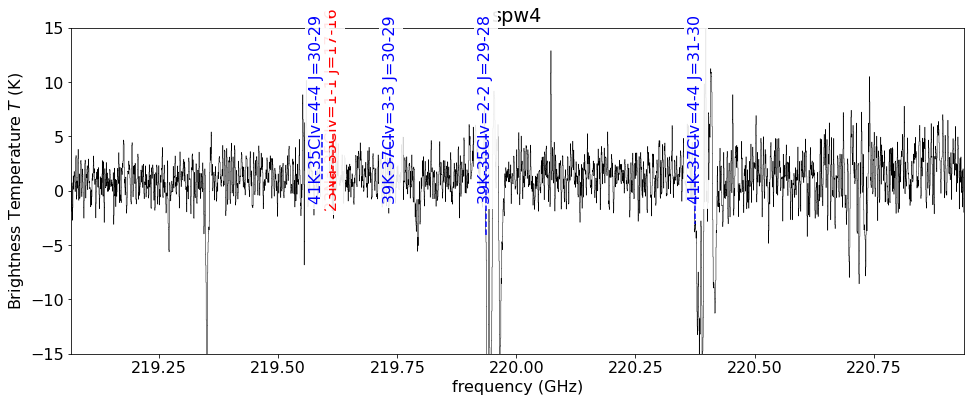

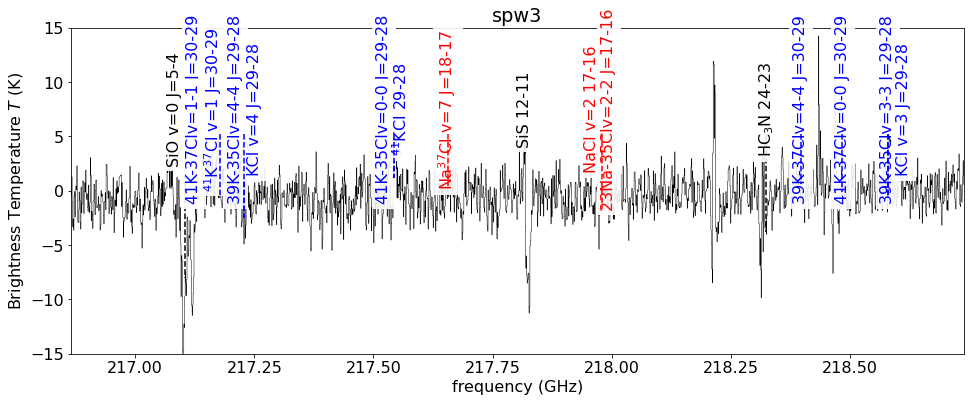

In [34]:
for fn in glob.glob('spectra/figures/color*png'):
    display(Image(fn))

In [35]:
import glob
import spectral_cube.analysis_utilities
import reproject
from tqdm.notebook import tqdm
from astropy import stats

for fn in cbflist:
    basename = os.path.split(fn)[-1].split(".fits")[0]
    try:
        cube = SpectralCube.read(fn, use_dask=True)
    except Exception as ex:
        print(ex)
        continue
    print(cube)
    scube = cube.subcube_from_regions(regsm).to(u.K)
    mx = scube.max(axis=0)
    #msk = mx > 0.003*mx.unit
    print("Mean spectrum")
    sp = scube.mean(axis=(1,2))
    rms = stats.mad_std(sp)
    print(f"rms={rms}")
    
    sp.write(f'spectra/{fn.split("/")[-1].replace(".fits","_meanspec.fits")}', overwrite=True)


    # reproject the velocity map into the cube's coordinate system
    vmap_proj,_ = reproject.reproject_interp(vmap,
                                             scube.wcs.celestial,
                                             shape_out=scube.shape[1:])
    vmap_proj = u.Quantity(vmap_proj, u.km/u.s)
    fits.PrimaryHDU(data=vmap_proj, header=scube.wcs.celestial.to_header()).writeto('vmap.fits')
    # convert to km/s with arbitrary rest value so 0 km/s can be interpreted
    if scube.spectral_axis.unit.is_equivalent(u.Hz):
        scube = scube.with_spectral_unit(u.km/u.s, velocity_convention='radio', rest_value=scube.spectral_axis.mean())

    print("Stacking")
    # perform the stacking!
    stack = spectral_cube.analysis_utilities.stack_spectra(scube, vmap_proj,
                                                           v0=0.0*u.km/u.s,
                                                           #progressbar=tqdm,
                                                           #num_cores=8
                                                          )
    fstack = stack.with_spectral_unit(u.GHz)

    pl.suptitle(f"{fn}")
    fstack.write(f'spectra/{basename}_stack.fits', overwrite=True)

    pl.clf()
    fstack.quicklook(filename=f'spectra/figures/{basename}_stack.pdf')
    fstack.quicklook(filename=f'spectra/figures/{basename}_stack.png')
    
    
    fig = pl.figure()
    mappable = pl.subplot(1,2,1).imshow(mx.value, origin='lower', interpolation='none')
    pl.colorbar(mappable)
    pl.subplot(1,2,2)
    pl.suptitle(fn)
    sp.quicklook()

DaskSpectralCube with shape=(1920, 718, 718) and unit=Jy / beam and chunk size (240, 255, 255):
 n_x:    718  type_x: RA---SIN  unit_x: deg    range:   270.125695 deg:  270.127876 deg
 n_y:    718  type_y: DEC--SIN  unit_y: deg    range:   -24.068119 deg:  -24.066127 deg
 n_s:   1920  type_s: FREQ      unit_s: Hz     range: 233565132698.900 Hz:235439188519.174 Hz


Mean spectrum
rms=1.4648004073984993 K
Stacking


ValueError: velocity_surface contains no finite values.

In [ ]:
ls spectra

In [ ]:
stackspectra = []
for ii,fn in enumerate(glob.glob('spectra/*_stack.fits')):
    pysp = pyspeckit.Spectrum(fn)
    basename = os.path.basename(fn)
    spl = basename.split(".")
    pysp.specname = f'{".".join(spl[0:3])}_{spl[4]}_stack.fits'
    print(pysp.specname)
    stackspectra.append(pysp)

In [ ]:
overplot_saltlines(stackspectra, vcen=0*u.km/u.s, savepath='spectra/figures')

In [ ]:
ls spectra/figures/

In [ ]:
for fn in glob.glob('spectra/figures/color*stack.png'):
    display(Image(fn))